### Importing Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
from tensorflow import keras 
from keras import Sequential
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet121
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [2]:
seed = 123  
# Loading the image from directory into train and validation sets
train_data = keras.utils.image_dataset_from_directory(
    directory='train_images',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="training",
    seed=seed  
)

val_data = keras.utils.image_dataset_from_directory(
    directory='train_images',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="validation",
    seed=seed  
)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.
Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


In [3]:
# Normalizing the data 
def preprocess(image,label):
    image = tf.cast(image/255,tf.float32)
    return image,label
train_data = train_data.map(preprocess)
val_data = val_data.map(preprocess) 

In [4]:
dataset_path = 'train_images'

# Count the number of subdirectories (classes)
num_classes = len([name for name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, name))])
print("Number of classes:", num_classes)

Number of classes: 10


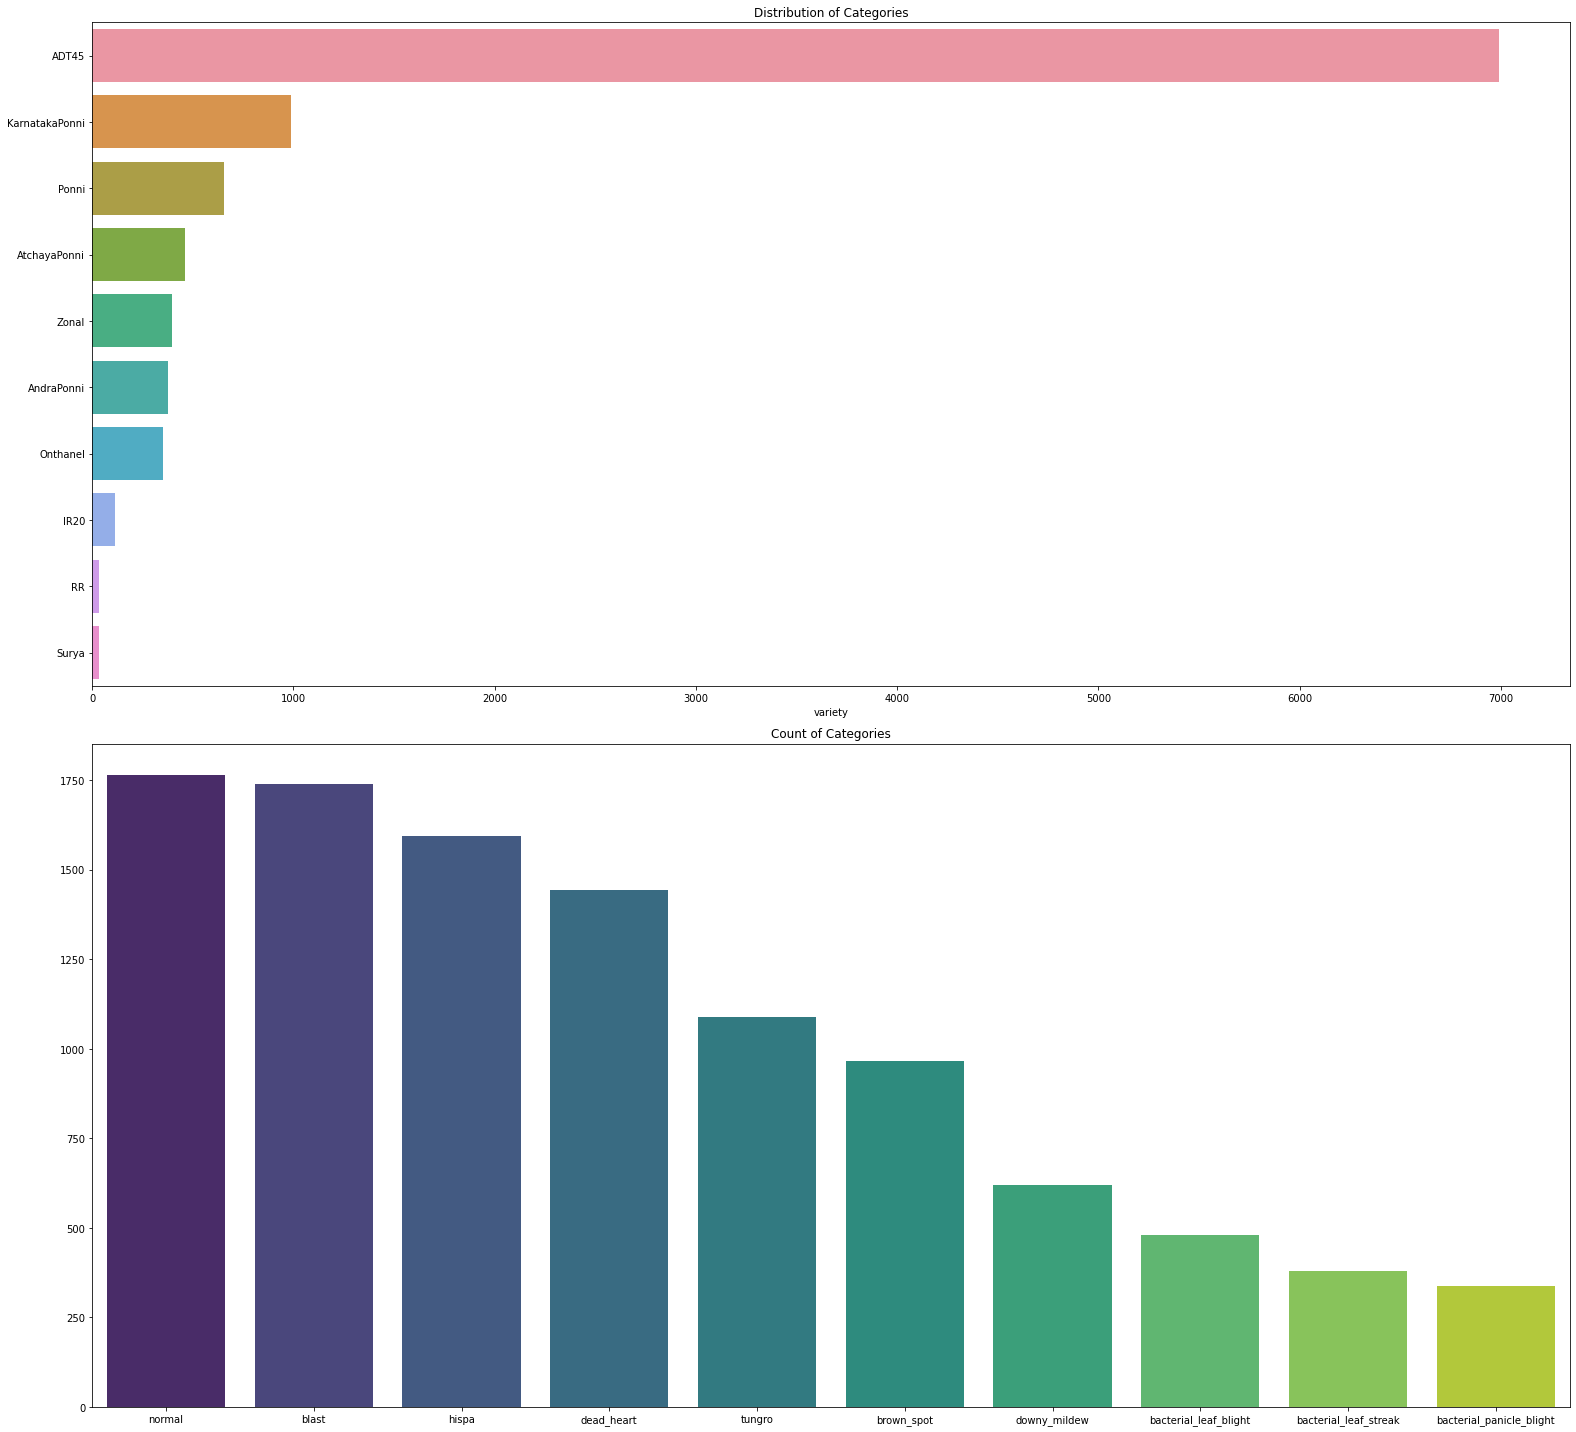

In [51]:
count_categories = df['label'].value_counts()
count_variety=df['variety'].value_counts()
fig, axs = plt.subplots(2, 1, figsize=(22, 20), facecolor='white')
palette = sns.color_palette("viridis")
sns.barplot(x=count_variety, y=count_variety.index,  ax=axs[0])
axs[0].set_title('Distribution of Categories')

sns.barplot(x=count_categories.index, y=count_categories.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')
plt.tight_layout()
plt.savefig("plot.png")
plt.show()

In [12]:
df = pd.read_csv("train.csv")
df['variety'].value_counts()

ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: variety, dtype: int64

### Preview of each category of images

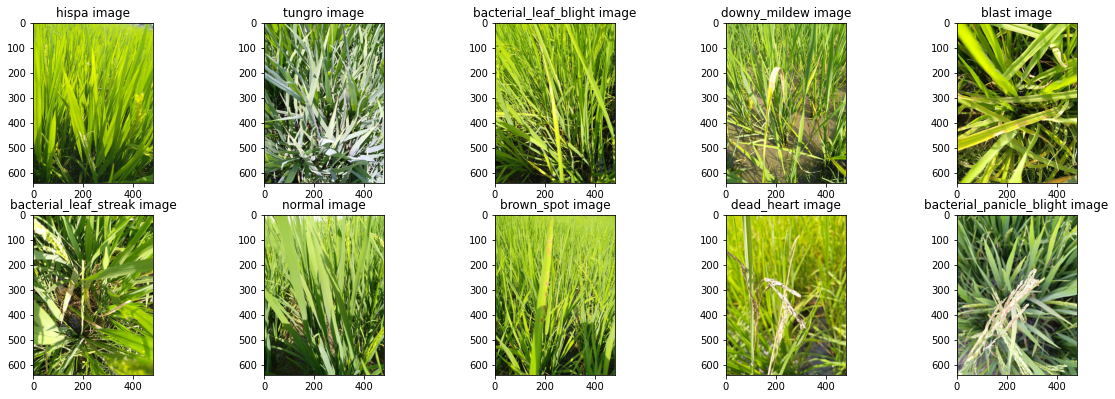

In [16]:
images = ['train_images/hispa/106590.jpg',
          'train_images/tungro/109629.jpg',
          'train_images/bacterial_leaf_blight/109372.jpg',
          'train_images/downy_mildew/102350.jpg',
          'train_images/blast/110243.jpg',
          'train_images/bacterial_leaf_streak/101104.jpg',
          'train_images/normal/109760.jpg',
          'train_images/brown_spot/104675.jpg',
          'train_images/dead_heart/105159.jpg',
          'train_images/bacterial_panicle_blight/101351.jpg',
          ]
diseases = ['hispa', 'tungro', 'bacterial_leaf_blight', 'downy_mildew', 'blast', 'bacterial_leaf_streak',
            'normal', 'brown_spot', 'dead_heart', 'bacterial_panicle_blight']
diseases = [disease + ' image' for disease in diseases]
plt.figure(figsize=(20, 10))
columns = 5
for i, image_loc in enumerate(images):
    plt.subplot(len(images)//columns + 1, columns, i + 1)
    image = plt.imread(image_loc)
    plt.title(diseases[i])
    plt.imshow(image)

### Building the DenseNet121 model

In [52]:
DenseNet121_model = DenseNet121(weights='imagenet',include_top=False, input_shape=(256, 256, 3), pooling = 'avg')

# Freeze the pre-trained base model layers
DenseNet121_model.trainable = False

model = Sequential()
# Add the pre-trained DenseNet121 base layer to the model architecture
model.add(DenseNet121_model)
model.add(BatchNormalization())
model.add(Dropout(0.35))
# Add a dense layer and ReLU activation function
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax')) # output layer

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 7,174,090
Trainable params: 134,538
Non-trainable params: 7,039,552
_________________________________________________________________


In [53]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    mode="auto", 
    restore_best_weights=True,
)
history = model.fit(train_data, validation_data=val_data, epochs=20,callbacks=[early_stopping] )

Epoch 1/20
261/261 [==============================] - 39s 126ms/step - loss: 1.2676 - accuracy: 0.5772 - val_loss: 0.9457 - val_accuracy: 0.7299
Epoch 2/20
261/261 [==============================] - 32s 121ms/step - loss: 0.7892 - accuracy: 0.7371 - val_loss: 0.6118 - val_accuracy: 0.8097
Epoch 3/20
261/261 [==============================] - 32s 122ms/step - loss: 0.6327 - accuracy: 0.7917 - val_loss: 0.4970 - val_accuracy: 0.8381
Epoch 4/20
261/261 [==============================] - 32s 123ms/step - loss: 0.5334 - accuracy: 0.8233 - val_loss: 0.4435 - val_accuracy: 0.8611
Epoch 5/20
261/261 [==============================] - 32s 124ms/step - loss: 0.4671 - accuracy: 0.8445 - val_loss: 0.4145 - val_accuracy: 0.8703
Epoch 6/20
261/261 [==============================] - 31s 120ms/step - loss: 0.4121 - accuracy: 0.8639 - val_loss: 0.3617 - val_accuracy: 0.8852
Epoch 7/20
261/261 [==============================] - 31s 119ms/step - loss: 0.3655 - accuracy: 0.8801 - val_loss: 0.3330 - val_ac

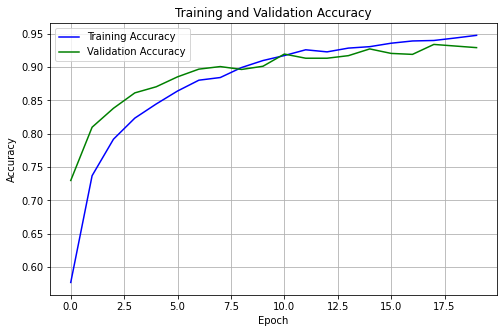

In [64]:
# Plotting the training and validation accuracy
plt.figure(figsize=(8, 5))
sns.lineplot(data=history.history['accuracy'], label='Training Accuracy', color='blue')
sns.lineplot(data=history.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(labels=['Training Accuracy', 'Validation Accuracy'])
plt.grid(True)
plt.show()

In [57]:
validation_loss, validation_accuracy = model.evaluate(val_data)

# Print the validation loss and accuracy
print("Validation Loss:", round(validation_loss,4)*100,"%")
print("Validation Accuracy:", round(validation_accuracy,4)*100,"%")

66/66 [==============================] - 7s 95ms/step - loss: 0.2462 - accuracy: 0.9289
Validation Loss: 24.62 %
Validation Accuracy: 92.89 %


### Prediction for test images

In [10]:
test_dir = 'test_images'
test_data = image_dataset_from_directory(
    test_dir,
    label_mode=None,
    shuffle=False,
    image_size=(256, 256),
    batch_size=32,
)


def preprocess(image):
    image = tf.cast(image / 255, tf.float32)
    return image

test_data = test_data.map(preprocess)

Found 3469 files belonging to 1 classes.


In [19]:
labels = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast',
               'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']
test_images=[]
# Predicting labels for test images
predicted_labels = []
for images in test_data:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels.extend(predicted_classes)
    test_images.extend(images.numpy())

# Map predicted class indices to class names
pred_label_names = [labels[prediction] for prediction in predicted_labels]

#predicted labels for the first few images
num_predictions = 10  
for idx, labels in enumerate(pred_label_names[:num_predictions]):
    print(f"Image {idx + 1}: Predicted Label: {labels}")

Image 1: Predicted Label: hispa
Image 2: Predicted Label: normal
Image 3: Predicted Label: blast
Image 4: Predicted Label: blast
Image 5: Predicted Label: blast
Image 6: Predicted Label: brown_spot
Image 7: Predicted Label: dead_heart
Image 8: Predicted Label: brown_spot
Image 9: Predicted Label: hispa
Image 10: Predicted Label: normal


In [13]:
prediction_df =pd.DataFrame({'label': pred_label_names})
prediction_df

,label
0,hispa
1,normal
2,blast
3,blast
4,blast
...,...
3464,dead_heart
3465,hispa
3466,normal
3467,blast


### Classified output of images

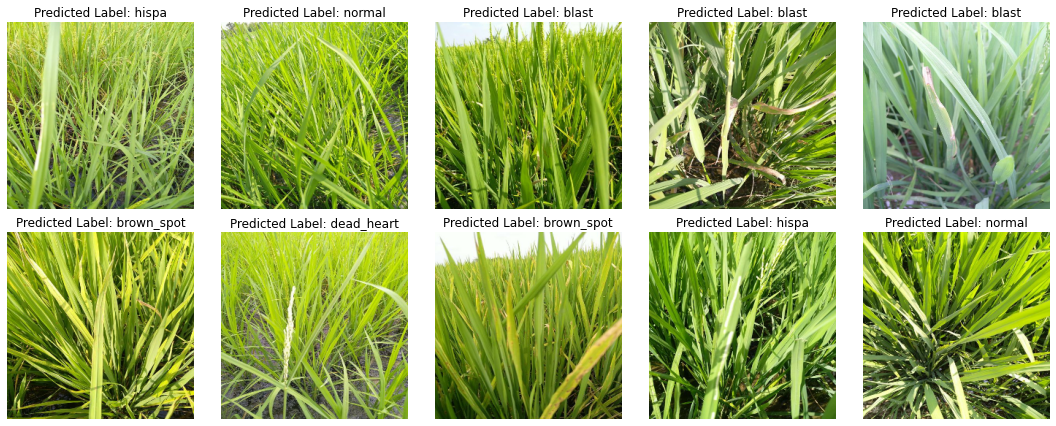

In [20]:
def display_images_with_labels(images, labels, num_images=10):
    num_images = min(num_images, len(images))
    
    #subplot grid based on the number of images
    num_rows = (num_images + 4) // 5
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
    
    # Iterate over the images and display them with their labels
    for i, (image, label) in enumerate(zip(images[:num_images], labels[:num_images])):
        ax = axes[i // 5, i % 5] if num_rows > 1 else axes[i % 5]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'Predicted Label: {label}')
    
    # Remove empty subplots if the number of images is not a multiple of 5
    for i in range(num_images, num_rows * 5):
        axes[i // 5, i % 5].remove()
    
    plt.tight_layout()
    plt.show()
display_images_with_labels(test_images, pred_label_names)